# New York City Taxi Fare Prediction

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read data

We're going to read the first 2 million rows because the file is large

In [2]:
file = 'data/train.csv'
train = pd.read_csv(file, nrows=2000000)

In [3]:
#dimensions
train.shape

(2000000, 8)

In [4]:
#overview of features and datatypes
train.dtypes

key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [5]:
#glance at the first 5 rows
train.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


We can visualize the distribution of the target variable

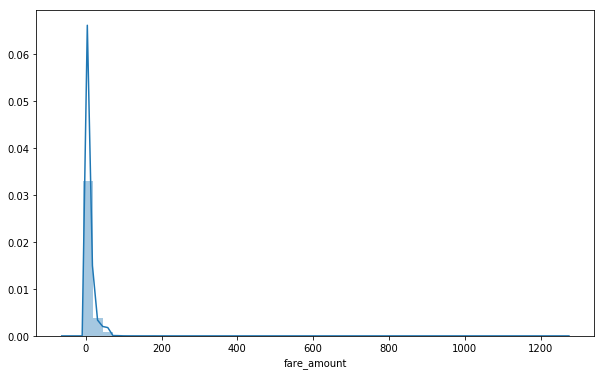

In [6]:
plt.figure(figsize = (10, 6))
sns.distplot(train['fare_amount'])

There appears to be some negative fare values and some extremely high fares. 2.50 is the minimum taxi fare in New York, so values less than that are errors. Values above $100 can also be removed

In [7]:
#removing instances with fare_amount < 2.5 or > 100
train = train[ (train['fare_amount'] > 2.5) & (train['fare_amount'] < 100) ]

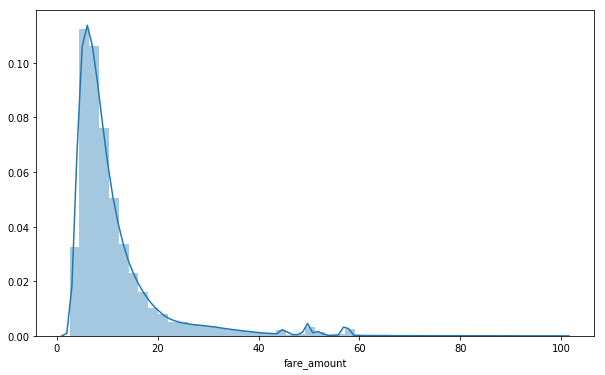

In [8]:
plt.figure(figsize = (10, 6))
sns.distplot(train['fare_amount'])

Now the fare_amount distribution looks right

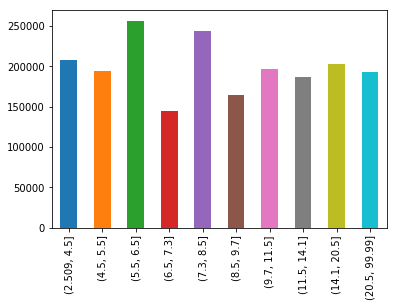

In [9]:
pd.qcut(train['fare_amount'], q = 10).value_counts().sort_index().plot.bar()

Now we'll look at the passenger_count variable. It looks like the maximum value is much greater than what would fit into a taxi. We can remove rows with passengers over 6. 

In [12]:
train['passenger_count'].describe()

count    1.990712e+06
mean     1.685099e+00
std      1.315537e+00
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.080000e+02
Name: passenger_count, dtype: float64

Now the passenger_count variable will look right

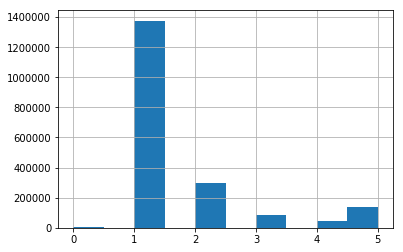

In [28]:
#remove rows with passenger_count > 6
train = train[train['passenger_count'] < 6]
train['passenger_count'].hist()

Next, we're going to add as features the latitudinal and longitudinal distance between pickup and dropoff locations

In [30]:
def add_distance_vector(df):
    df['diff_longitude'] = abs(df['pickup_longitude'] - df['dropoff_longitude'])
    df['diff_latitude'] = abs(df['pickup_latitude'] - df['dropoff_latitude'])

In [32]:
add_distance_vector(train)

## Explore the data

In [33]:
print('NaNs in dropoff_longitude:', train['dropoff_longitude'].isnull().sum())
print('NaNs in dropoff_latitude:', train['dropoff_latitude'].isnull().sum())

NaNs in dropoff_longitude: 14
NaNs in dropoff_latitude: 14


Since there are so few Nans, we can drop those rows

In [34]:
train.dropna(inplace=True)

In [35]:
train.shape

(1948819, 10)

We'll plot a scatter plot of diff_latitude and diff_longitude features to see what values aren't normal

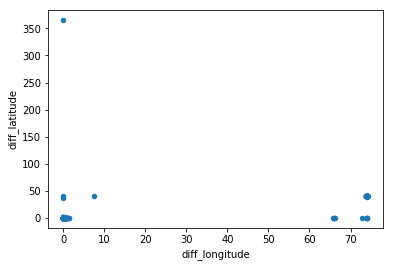

In [41]:
train.sample(50000).plot.scatter('diff_longitude', 'diff_latitude')

We'll remove outliers (instances where difference in latitude or longitude is greater than 10)

In [42]:
train = train[(train['diff_longitude'] < 10) & (train['diff_latitude'] < 10)]

In [43]:
train.shape

(1945357, 10)

We can also check if passenger_count influences fare_amount

In [47]:
train[['fare_amount', 'passenger_count']].corr()

,fare_amount,passenger_count
fare_amount,1.000000,0.009684
passenger_count,0.009684,1.000000


There is no correlation, so we do not need to include this feature for training

# Train the model

We will create the input vector that consists of the diff_latitude and diff_longitude features and also a column of ones to allow matrix multiplication

In [57]:
def create_input_vector(df):
    return np.column_stack((df['diff_longitude'], df['diff_latitude'], np.ones(len(df))))

X = create_input_vector(train)
y = np.array(train['fare_amount'])

In [58]:
print(X.shape)
print(y.shape)

(1945357, 3)
(1945357,)


In [59]:
w, _, _, _ = np.linalg.lstsq(X, y, rcond = None)

In [60]:
print(w)

[116.00757451  57.30444802   7.47085847]


# Predictions

In [61]:
test = pd.read_csv('data/test.csv')

In [62]:
test.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

We can use the previously defined functions to create the features and the test vector

In [63]:
add_distance_vector(test)
X = create_input_vector(test)

Now we can make predictions based on our calculated weights vector w 

In [64]:
predictions = np.matmul(X, w).round(decimals=2)

Create the submission file

In [66]:
submission = pd.DataFrame(
    {'key': test.key, 'fare_amount': predictions},
    columns = ['key', 'fare_amount'])
submission.to_csv('output/submission.csv', index = False)